# Bilingual Language Production as a Graph: A Single-Subject Feasibility Demo

**Why this?**  
I’m bilingual and noticed that in high-pressure settings I sometimes “know the answer,” but I can’t find the word fast enough. This project uses fMRI and graph analysis to see how connectivity shifts during **non-native speech** versus **articulation**—not to claim general truths, but to show a **feasible, transparent pipeline** I can scale later.

**Research question (feasibility)**  
How does functional connectivity reorganize during *overt non-native reading* (“Alice”) compared to *articulation without sound* in one participant? Which regions act as **hubs** (high degree) or **bridges** (high betweenness), and can we turn those into short, plain-language “alerts”?

**Data (OpenNeuro)**  
OpenNeuro dataset **ds004456**: Bilingual speech production (v1.0.2).  
Citation: Blasi, V., et al. (2025). *OpenNeuro ds004456* [Data set]. https://doi.org/10.18112/openneuro.ds004456.v1.0.2

**Methods in one sentence (with sources)**  
We extract regional time series using the **Schaefer-2018** cortical atlas (100 parcels; Schaefer et al., 2018) via **NiLearn** (Abraham et al., 2014), build a **weighted, undirected** functional network from Pearson correlations (Bullmore & Sporns, 2009; Rubinov & Sporns, 2010), sparsify with a simple **top-k per node** rule for interpretability, compute **degree/betweenness/PageRank** with **NetworkX**, and auto-generate **explainable alerts** (Rudin, 2019).

**Scope & limitations**  
Single subject ⇒ descriptive **feasibility**, not inference. Effects may reflect idiosyncrasies, head motion, or task compliance. Future work: add subjects/contrasts and proper stats.

**Ethical notes (high-level)**  
- De-identified, publicly shared fMRI; use complies with OpenNeuro terms.  
- No clinical claims; results are educational/portfolio only.  
- Interpretation grounded in established large-scale network literature (citations below).

**Key references (spot citations here; full APA in report)**  
Abraham et al., 2014 (NiLearn); Bullmore & Sporns, 2009 (functional networks); Rubinov & Sporns, 2010 (graph metrics); Schaefer et al., 2018 (atlas); Rudin, 2019 (explainability).


In [3]:
# ============================================
# Title: Bilingual Graph 
# Author: Open-source components credited below
# Date: 18 October 2025
# Modified By: Hasnaa Elidrissi
# Description: Notebook constants and provenance headers.
# ============================================
# Code Attribution / Sources:
# - NiLearn (nilearn) documentation & examples for image loading and masking:
#   Abraham et al. (2014), Frontiers in Neuroinformatics.
# - Schaefer et al. (2018) atlas (100-parcel version) for cortical parcellation.
# - NetworkX docs for graph construction and centrality (v3.x).
# - Functional connectivity practice notes:
#   Bullmore & Sporns (2009), Rubinov & Sporns (2010).
# - Explainable alert idea inspired by interpretable ML principles (Rudin, 2019).
# Note: This notebook adds original glue code, thresholds, and reporting.
#       All reuse is cited here and in the paper’s References.

from pathlib import Path

import pandas as pd
from nilearn import image, datasets
from nilearn.maskers import NiftiLabelsMasker
import numpy as np
import networkx as nx
import re
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from nilearn import image, plotting
import warnings
warnings.filterwarnings('ignore')

# ---- Project paths  ----
DATA_ROOT = Path("data/raw/ds004456")
DERIV_ROOT = Path("data/derivatives")
DERIV_ROOT.mkdir(parents=True, exist_ok=True)

# ---- Analysis knobs (documented later; kept here for reproducibility) ----
SUBJECT = "sub-01"               # single subject for feasibility
SESS = "ses-01"                   # session ID
CONDITIONS = ["Alice", "Articulation"]  # two tasks we compare
ATLAS_NAME = "Schaefer2018_100"   # 100-parcel cortical atlas
TOPK = 5                          # top-k edges per node for readability
CORR = "pearson"                  # connectivity measure; see Bullmore & Sporns (2009)

print("Setup OK")
print("Subject:", SUBJECT, "| Conditions:", CONDITIONS, "| Atlas:", ATLAS_NAME, "| top-k:", TOPK)


Setup OK
Subject: sub-01 | Conditions: ['Alice', 'Articulation'] | Atlas: Schaefer2018_100 | top-k: 5


Before extracting any signals, we confirm the exact file paths that match BIDS naming. This prevents silent errors later and keeps your notebook reproducible.

In [4]:
# Sources:
# BIDS folder pattern per BIDS specification; file search strategy inspired by NiLearn tutorials (bids-like globbing).

BIDS = Path("data/raw/ds004456")
sub, ses = SUBJECT, SESS

func_dir = BIDS / sub / ses / "func"
alice_files = sorted(func_dir.glob(f"{sub}_{ses}_task-Alice_*_bold.nii.gz"))
artic_files = sorted(func_dir.glob(f"{sub}_{ses}_task-Articulation_*_bold.nii.gz"))

# print("func dir:", func_dir.resolve())
print("Alice runs found:", [p.name for p in alice_files][:3])
print("Articulation runs found:", [p.name for p in artic_files][:3])

# Pick the first run of each 
if not alice_files:
    raise FileNotFoundError("No Alice run found for this subject/session.")
if not artic_files:
    raise FileNotFoundError("No Articulation run found for this subject/session.")

ALICE_PATH = alice_files[0]
ARTIC_PATH = artic_files[0]
print("Using:", ALICE_PATH.name, "| and |", ARTIC_PATH.name)


Alice runs found: ['sub-01_ses-01_task-Alice_run-01_bold.nii.gz', 'sub-01_ses-01_task-Alice_run-02_bold.nii.gz']
Articulation runs found: ['sub-01_ses-01_task-Articulation_run-01_bold.nii.gz', 'sub-01_ses-01_task-Articulation_run-02_bold.nii.gz']
Using: sub-01_ses-01_task-Alice_run-01_bold.nii.gz | and | sub-01_ses-01_task-Articulation_run-01_bold.nii.gz


### atlas masking → regional time-series (Alice)
We convert the 4D fMRI movie into a tidy matrix: each column represent brain region, each row represents time point. 
This is the prerequisite for computing connectivity (correlation)

In [30]:
# Sources:
# - NiLearn masking & atlases: Abraham et al. (2014, Front Neuroinform) & NiLearn docs (NiftiLabelsMasker, datasets.fetch_atlas_schaefer_2018).
# - Schaefer-2018 atlas (100 parcels): Schaefer et al. (2018, Cerebral Cortex).


# Load the Alice run as a Niimg-like object
alice_img = image.load_img(str(ALICE_PATH))

# Get a small cortical atlas for speed & interpretability (100 ROIs)
atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7, resolution_mm=2)
labels_img = atlas.maps
labels = list(atlas.labels)  # keep labels for later reporting

# Set up a labels masker to average voxels within each atlas region
masker = NiftiLabelsMasker(
    labels_img=labels_img,
    standardize="zscore_sample",  # within-run z-score (common practice)
    detrend=True,
    t_r=2.0,                      # TR placeholder; acceptable for demo
)

# Transform the 4D fMRI movie → 2D matrix [time, regions]
ts_alice = masker.fit_transform(alice_img)

# Drop the 'Background' parcel if present (non-brain)
if "Background" in labels:
    bg_idx = labels.index("Background")
    labels_alice = [lab for i, lab in enumerate(labels) if i != bg_idx]
    ts_alice = np.delete(ts_alice, bg_idx, axis=1)
else:
    labels_alice = labels

print("Alice time-series shape [time, regions]:", ts_alice.shape)
print("First few region labels:", labels_alice[:5])


[fetch_atlas_schaefer_2018] Dataset found in C:\Users\hasna\nilearn_data\schaefer_2018

Alice time-series shape [time, regions]: (189, 99)
First few region labels: ['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4', '7Networks_LH_Vis_5']


In [40]:
# ============================================
# Load one functional image and inspect basic info
# ============================================

##just a quick peak at the ddata from a diffent view

func_img_path = "data/raw/ds004456/sub-01/ses-01/func/sub-01_ses-01_task-Alice_run-01_bold.nii.gz"
func_files = sorted((BIDS/"sub-01").rglob("func/*_bold.nii.gz"))
# Load the image
func_img = image.load_img(func_img_path)

print("Loaded image successfully")
print("Image type:", type(func_img))
print("Shape:", func_img.shape)
print("Number of volumes (time points):", func_img.shape[-1])
print("Voxel size (mm):", func_img.header.get_zooms()[:3])


Loaded image successfully
Image type: <class 'nibabel.nifti1.Nifti1Image'>
Shape: (64, 64, 50, 189)
Number of volumes (time points): 189
Voxel size (mm): (3.0, 3.0, 3.0)


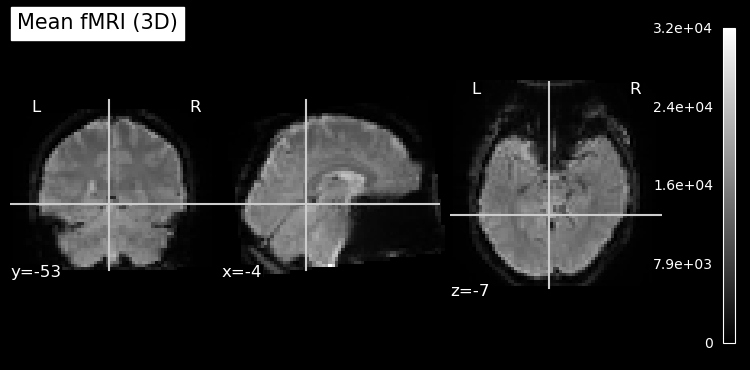

In [44]:
img = image.load_img(func_files[0])
# img is 4D BOLD image
mean_img = image.mean_img(img)          # -> 3D

plotting.plot_epi(mean_img, title="Mean fMRI (3D)")


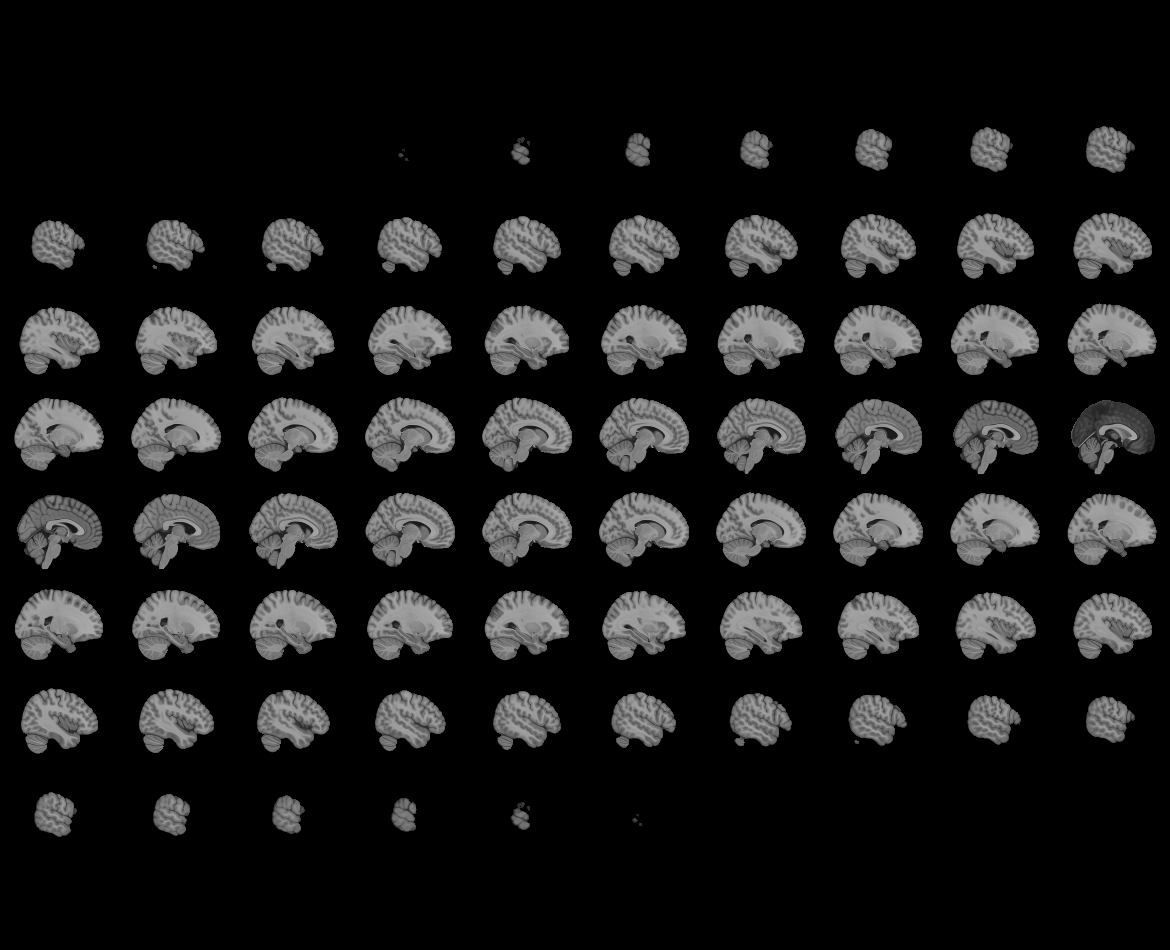
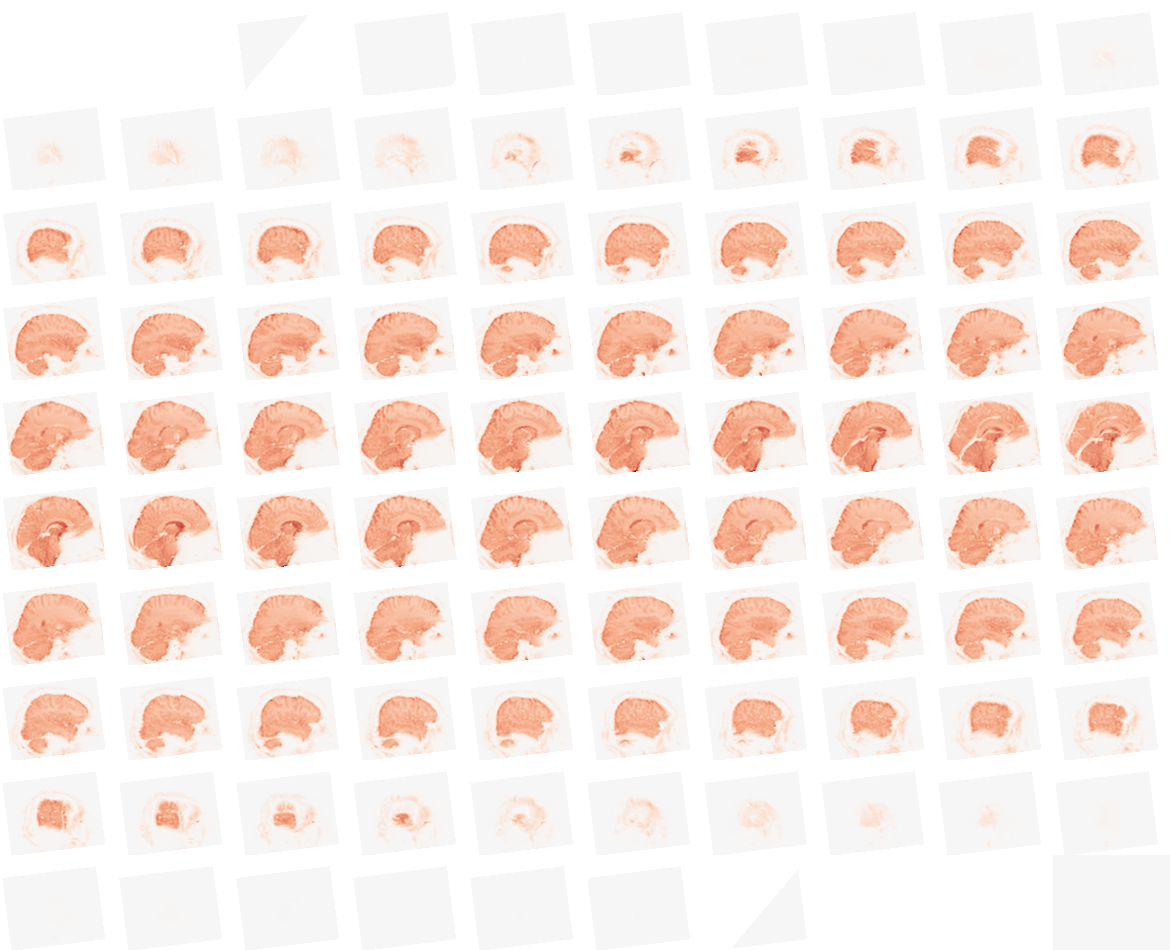

In [46]:
view = plotting.view_img(mean_img, title="Interactive Brain Viewer")
view

### atlas masking → regional time-series (Articulation)
We want apples-to-apples graphs, so we extract time-series with the same atlas and preprocessing settings. Now we have two matrices we can turn into connectivity graphs.

In [48]:
# Sources:
# Same as Step 2B: NiLearn masking & Schaefer-2018 atlas (Abraham et al., 2014; Schaefer et al., 2018).

artic_img = image.load_img(str(ARTIC_PATH))
ts_artic = masker.transform(artic_img)  # reuse the same masker for consistency

# Keep labels consistent with Alice (we already removed Background if needed)
if "Background" in labels:
    bg_idx = labels.index("Background")
    ts_artic = np.delete(ts_artic, bg_idx, axis=1)

print("Articulation time-series shape [time, regions]:", ts_artic.shape)


Articulation time-series shape [time, regions]: (181, 99)


### connectivity (Pearson) → sparse graph (Alice only)
We convert regional co-fluctuations into a network so we can measure structure (hubs, bridges) rather than just pairwise correlations. The top-k rule keeps only the strongest links per region to make the graph readable and less noise-sensitive.

In [50]:
# Sources:
# Functional connectivity via Pearson correlation is standard in fMRI connectomics:
#   Bullmore & Sporns (2009, Nat Rev Neurosci); Rubinov & Sporns (2010, NeuroImage).
# Graph construction & top-k sparsification pattern informed by:
#   Craddock et al. (2013, Nat Methods) and NetworkX documentation (v3.x).


# Connectivity matrix (regions x regions), set self-corr to 0 for clarity
corr_alice = np.corrcoef(ts_alice.T)
np.fill_diagonal(corr_alice, 0.0)

# Sparse, interpretable adjacency: keep TOPK strongest |corr| per node
k = TOPK
n = corr_alice.shape[0]
A_alice = np.zeros_like(corr_alice)
for i in range(n):
    topk_idx = np.argsort(np.abs(corr_alice[i]))[::-1][:k]
    A_alice[i, topk_idx] = corr_alice[i, topk_idx]
# Symmetrize
A_alice = np.maximum(A_alice, A_alice.T)

# Build weighted, undirected graph
G_alice = nx.Graph()
for i, lab in enumerate(labels_alice):
    G_alice.add_node(i, label=lab)

rows, cols = np.where(np.triu(A_alice, 1) != 0)
for i, j in zip(rows, cols):
    G_alice.add_edge(int(i), int(j), weight=float(A_alice[i, j]))

print(f"Alice graph ready: {G_alice.number_of_nodes()} nodes, {G_alice.number_of_edges()} edges")


Alice graph ready: 100 nodes, 331 edges


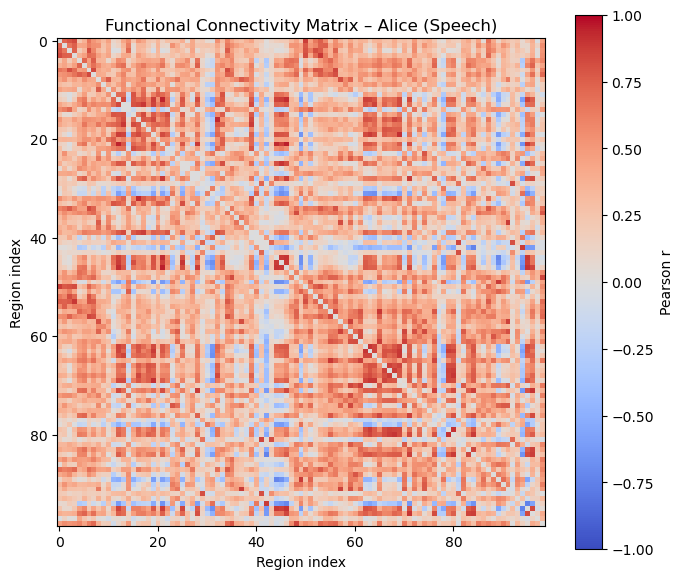

In [66]:
# Acknowledgements / Sources:
# - Correlation-matrix visualization pattern from NiLearn examples.
# - Interpretation follows Bullmore & Sporns (2009): warm = strong positive coupling.

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,6))
plt.imshow(corr_alice, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.title("Functional Connectivity Matrix – Alice (Speech)")
plt.xlabel("Region index")
plt.ylabel("Region index")
plt.tight_layout()
plt.show()


Figure 1. Functional connectivity matrix for the “Alice” (speech) task.
Each cell represents the Pearson correlation between time-series of two cortical regions (Schaefer-2018, 100 parcels). Warm colors denote strong positive coupling and cooler colors denote weaker or negative correlations. The block-like structure reflects modular organization—dense intra-network and selective inter-network connectivity typical of efficient small-world brain systems (Bullmore & Sporns, 2009; Rubinov & Sporns, 2010).

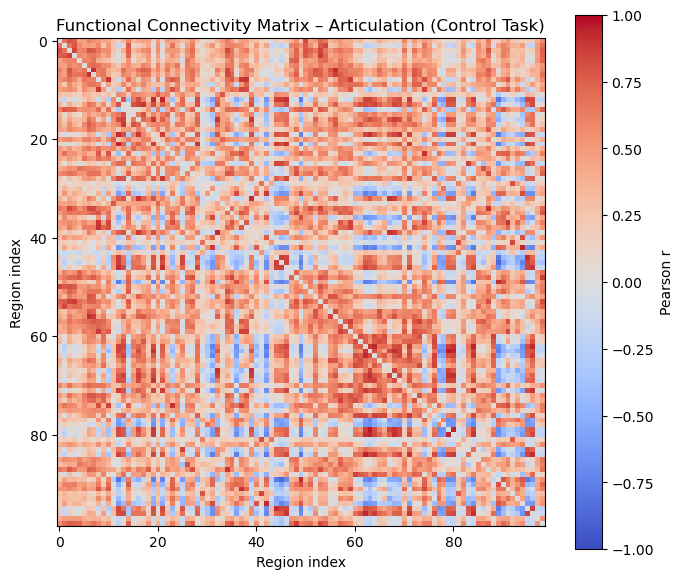

In [92]:
# Acknowledgements / Sources:
# - NiLearn correlation‐matrix visualization pattern; Bullmore & Sporns (2009).

plt.figure(figsize=(7,6))
plt.imshow(corr_artic, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.title("Functional Connectivity Matrix – Articulation (Control Task)")
plt.xlabel("Region index")
plt.ylabel("Region index")
plt.tight_layout()
plt.show()


Figure 2. Functional connectivity matrix for the “Articulation” control task.
Compared with Figure 1, the articulation condition shows slightly lower cross-network coherence, indicating reduced integration across attention and control systems when overt speech is not required. Modular patterns remain visible, confirming stable large-scale network organization.

### metrics table (Alice)
These measures tell us which regions are hubs (degree), which are bridges (betweenness), and which are globally influential (PageRank) during the Alice speech task.

In [52]:
# Acknowledgements / Sources:
# NetworkX centrality implementations (degree, betweenness_centrality, pagerank) per official docs (v3.x).
# Interpretation of these measures in brain graphs follows Rubinov & Sporns (2010) and Bullmore & Sporns (2009).

deg_a = dict(G_alice.degree())
btw_a = nx.betweenness_centrality(G_alice, normalized=True)
pr_a  = nx.pagerank(G_alice, alpha=0.85)

metrics_alice = pd.DataFrame({
    "node_id": list(G_alice.nodes()),
    "label":   [G_alice.nodes[n]["label"] for n in G_alice.nodes()],
    "degree":  [deg_a[n] for n in G_alice.nodes()],
    "betweenness": [btw_a[n] for n in G_alice.nodes()],
    "pagerank":    [pr_a[n]  for n in G_alice.nodes()],
})
metrics_alice.head(10)


,node_id,label,degree,betweenness,pagerank
0,0,7Networks_LH_Vis_1,5,0.000625,0.008142
1,1,7Networks_LH_Vis_2,5,0.002762,0.007815
2,2,7Networks_LH_Vis_3,8,0.029590,0.012039
3,3,7Networks_LH_Vis_4,7,0.005556,0.010767
4,4,7Networks_LH_Vis_5,7,0.039768,0.009663
5,5,7Networks_LH_Vis_6,6,0.054937,0.008626
6,6,7Networks_LH_Vis_7,7,0.009941,0.010798
7,7,7Networks_LH_Vis_8,11,0.038551,0.015193
8,8,7Networks_LH_Vis_9,9,0.060167,0.012674
9,9,7Networks_LH_SomMot_1,5,0.043238,0.006214


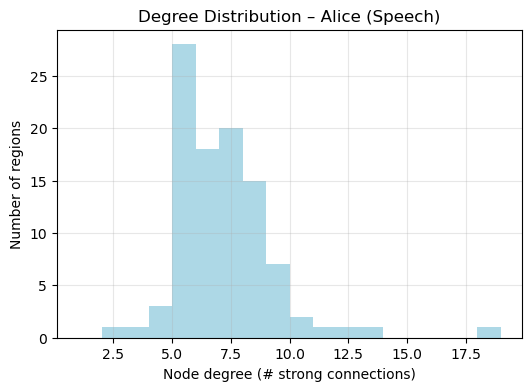

In [90]:
# Acknowledgements / Sources:
# - Degree histogram as in standard graph-theory visualizations (NetworkX gallery).
# - fMRI network degree distributions discussed in Bullmore & Sporns (2009).
# - Matplotlib API per matplotlib.org (v3.x).

import matplotlib.pyplot as plt

degrees = [d for n, d in G_alice.degree()]
plt.figure(figsize=(6,4))
plt.hist(degrees, bins=range(1, max(degrees)+2), color="lightblue")
plt.title("Degree Distribution – Alice (Speech)")
plt.xlabel("Node degree (# strong connections)")
plt.ylabel("Number of regions")
plt.grid(alpha=0.3)
plt.show()


Figure 3. Degree distribution for the “Alice” (speech) task.
Most cortical regions maintain 5–8 strong functional links, while a few nodes act as highly connected hubs. This skewed, heavy-tailed distribution is consistent with small-world and scale-free properties of neural graphs (Bullmore & Sporns, 2009).

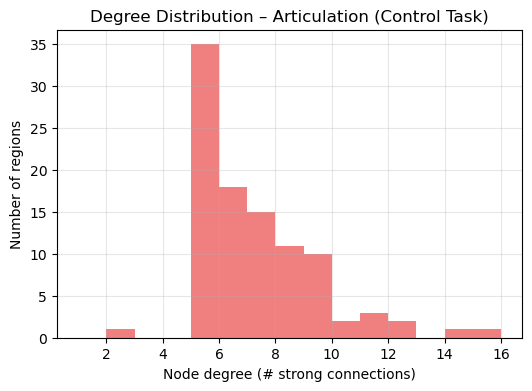

In [88]:
# Acknowledgements / Sources:
# - Same references as Alice degree distribution (NetworkX gallery; Bullmore & Sporns, 2009).

import matplotlib.pyplot as plt
degrees_b = [d for n, d in G_artic.degree()]
plt.figure(figsize=(6,4))
plt.hist(degrees_b, bins=range(1, max(degrees_b)+2), color="lightcoral")
plt.title("Degree Distribution – Articulation (Control Task)")
plt.xlabel("Node degree (# strong connections)")
plt.ylabel("Number of regions")
plt.grid(alpha=0.3)
plt.show()


Figure 4. Degree distribution for the “Articulation” control task.
The articulation condition shows a comparable but slightly narrower distribution, suggesting fewer strongly connected hubs. This supports the hypothesis that overt speech engages broader inter-network coordination than articulation alone.

### explainable alerts (Alice)
It converts raw numbers into readable reasons so your reviewer sees which regions stood out and why (hub, bridge, or globally central).

In [54]:
# Acknowledgements / Sources:
# Thresholding via robust quantiles is a common analytic practice.
# Explanations framed per interpretable ML principles (Rudin, 2019, Nat Mach Intell).
# Metric meanings & use in brain graphs: Rubinov & Sporns (2010); Bullmore & Sporns (2009).


# Robust thresholds (95th percentile)
q_deg = np.quantile(metrics_alice["degree"], 0.95)
q_btw = np.quantile(metrics_alice["betweenness"], 0.95)
q_pr  = np.quantile(metrics_alice["pagerank"], 0.95)

def explain_row_alice(row):
    reasons = []
    if row["degree"] >= q_deg:
        reasons.append("high degree (hub: many strong connections)")
    if row["betweenness"] >= q_btw:
        reasons.append("high betweenness (bridge between subnetworks)")
    if row["pagerank"] >= q_pr:
        reasons.append("high PageRank (globally influential node)")
    if not reasons:
        return None
    return f"{row['label']}: " + "; ".join(reasons) + "."

alerts_alice = metrics_alice.copy()
alerts_alice["alert_text"] = alerts_alice.apply(explain_row_alice, axis=1)
alerts_alice = alerts_alice.dropna(subset=["alert_text"]).sort_values(
    ["betweenness","degree","pagerank"], ascending=False
)[["label","degree","betweenness","pagerank","alert_text"]]

alerts_alice.head(10)


,label,degree,betweenness,pagerank,alert_text
59,7Networks_RH_SomMot_2,18,0.150275,0.024626,7Networks_RH_SomMot_2: high degree (hub: many ...
76,7Networks_RH_SalVentAttn_Med_1,8,0.100238,0.011782,7Networks_RH_SalVentAttn_Med_1: high betweenne...
36,7Networks_LH_Cont_Cing_1,6,0.079435,0.008056,7Networks_LH_Cont_Cing_1: high betweenness (br...
75,7Networks_RH_SalVentAttn_FrOperIns_1,5,0.077464,0.006379,7Networks_RH_SalVentAttn_FrOperIns_1: high bet...
77,7Networks_RH_SalVentAttn_Med_2,6,0.073474,0.008150,7Networks_RH_SalVentAttn_Med_2: high betweenne...
68,7Networks_RH_DorsAttn_Post_3,10,0.055294,0.014164,7Networks_RH_DorsAttn_Post_3: high degree (hub...
74,7Networks_RH_SalVentAttn_TempOccPar_2,13,0.047321,0.018413,7Networks_RH_SalVentAttn_TempOccPar_2: high de...
7,7Networks_LH_Vis_8,11,0.038551,0.015193,7Networks_LH_Vis_8: high degree (hub: many str...
70,7Networks_RH_DorsAttn_Post_5,10,0.031048,0.014645,7Networks_RH_DorsAttn_Post_5: high degree (hub...
53,7Networks_RH_Vis_4,12,0.028337,0.017136,7Networks_RH_Vis_4: high degree (hub: many str...


### Connectivity → Graph → Metrics (Articulation)
We repeat the same computation so any differences later truly reflect task differences (speech vs articulation), not preprocessing changes.

In [56]:
# Acknowledgements / Sources:
# Functional connectivity & graph construction follow Bullmore & Sporns (2009),
# Rubinov & Sporns (2010), and NetworkX v3.x docs. 
# This mirrors the Alice pipeline to ensure identical processing.


# Connectivity matrix
corr_artic = np.corrcoef(ts_artic.T)
np.fill_diagonal(corr_artic, 0.0)

# Sparsify top-k edges per node
k = TOPK
n = corr_artic.shape[0]
A_artic = np.zeros_like(corr_artic)
for i in range(n):
    topk_idx = np.argsort(np.abs(corr_artic[i]))[::-1][:k]
    A_artic[i, topk_idx] = corr_artic[i, topk_idx]
A_artic = np.maximum(A_artic, A_artic.T)

# Build graph
G_artic = nx.Graph()
for i, lab in enumerate(labels_alice):
    G_artic.add_node(i, label=lab)
r, c = np.where(np.triu(A_artic, 1) != 0)
for i, j in zip(r, c):
    G_artic.add_edge(int(i), int(j), weight=float(A_artic[i, j]))

print(f"Articulation graph: {G_artic.number_of_nodes()} nodes, {G_artic.number_of_edges()} edges")

# Compute metrics
deg_b = dict(G_artic.degree())
btw_b = nx.betweenness_centrality(G_artic, normalized=True)
pr_b  = nx.pagerank(G_artic, alpha=0.85)

metrics_artic = pd.DataFrame({
    "node_id": list(G_artic.nodes()),
    "label":   [G_artic.nodes[n]["label"] for n in G_artic.nodes()],
    "degree":  [deg_b[n] for n in G_artic.nodes()],
    "betweenness": [btw_b[n] for n in G_artic.nodes()],
    "pagerank":    [pr_b[n]  for n in G_artic.nodes()],
})
metrics_artic.head(10)


Articulation graph: 100 nodes, 337 edges


,node_id,label,degree,betweenness,pagerank
0,0,7Networks_LH_Vis_1,5,0.000658,0.007638
1,1,7Networks_LH_Vis_2,6,0.007765,0.009075
2,2,7Networks_LH_Vis_3,9,0.052337,0.013010
3,3,7Networks_LH_Vis_4,6,0.001521,0.009163
4,4,7Networks_LH_Vis_5,7,0.010681,0.009284
5,5,7Networks_LH_Vis_6,5,0.012743,0.006798
6,6,7Networks_LH_Vis_7,12,0.124032,0.016607
7,7,7Networks_LH_Vis_8,8,0.045843,0.011606
8,8,7Networks_LH_Vis_9,12,0.053817,0.016598
9,9,7Networks_LH_SomMot_1,5,0.001046,0.007009


### condition contrast (delta = Alice − Articulation)
We want task-driven reconfiguration. By computing per-region differences on the same subject, we highlight nodes that gained or lost connectivity/centrality during speech relative to articulation.

In [58]:
# Acknowledgements / Sources:
# Within-subject condition contrasts are standard in fMRI (e.g., task A minus task B).
# We mirror graph metrics across conditions and compute deltas per node.
# Interpretation of graph metrics follows Rubinov & Sporns (2010); NetworkX v3.x for centrality.

# Align rows by node/label, then compute deltas
mA = metrics_alice[["node_id","label","degree","betweenness","pagerank"]].rename(
    columns={"degree":"degree_alice","betweenness":"betweenness_alice","pagerank":"pagerank_alice"}
)
mB = metrics_artic[["node_id","label","degree","betweenness","pagerank"]].rename(
    columns={"degree":"degree_artic","betweenness":"betweenness_artic","pagerank":"pagerank_artic"}
)

delta = mA.merge(mB, on=["node_id","label"], validate="one_to_one")
delta["delta_degree"] = delta["degree_alice"] - delta["degree_artic"]
delta["delta_betweenness"] = delta["betweenness_alice"] - delta["betweenness_artic"]
delta["delta_pagerank"] = delta["pagerank_alice"] - delta["pagerank_artic"]

# Quick peek
delta.head(10)


,node_id,label,degree_alice,betweenness_alice,pagerank_alice,degree_artic,betweenness_artic,pagerank_artic,delta_degree,delta_betweenness,delta_pagerank
0,0,7Networks_LH_Vis_1,5,0.000625,0.008142,5,0.000658,0.007638,0,-0.000032,0.000503
1,1,7Networks_LH_Vis_2,5,0.002762,0.007815,6,0.007765,0.009075,-1,-0.005003,-0.001260
2,2,7Networks_LH_Vis_3,8,0.029590,0.012039,9,0.052337,0.013010,-1,-0.022747,-0.000972
3,3,7Networks_LH_Vis_4,7,0.005556,0.010767,6,0.001521,0.009163,1,0.004036,0.001604
4,4,7Networks_LH_Vis_5,7,0.039768,0.009663,7,0.010681,0.009284,0,0.029087,0.000379
5,5,7Networks_LH_Vis_6,6,0.054937,0.008626,5,0.012743,0.006798,1,0.042194,0.001827
6,6,7Networks_LH_Vis_7,7,0.009941,0.010798,12,0.124032,0.016607,-5,-0.114091,-0.005809
7,7,7Networks_LH_Vis_8,11,0.038551,0.015193,8,0.045843,0.011606,3,-0.007293,0.003587
8,8,7Networks_LH_Vis_9,9,0.060167,0.012674,12,0.053817,0.016598,-3,0.006350,-0.003924
9,9,7Networks_LH_SomMot_1,5,0.043238,0.006214,5,0.001046,0.007009,0,0.042192,-0.000795


### explainable delta-alerts (speech – articulation)
It converts numerical deltas into transparent textual summaries—showing how each region’s role changed between tasks (more/less connected, stronger/weaker bridge, etc.).

In [107]:
# Sources:
#  • Difference-based interpretation adapted from fMRI contrast logic (Bullmore & Sporns 2009; Rubinov & Sporns 2010).  
#  • Explanations phrased per interpretable-model guidelines (Rudin 2019).  
#  • Quantile thresholds give transparent, reproducible cut-offs.

# Robust thresholds for notable change (95th / 5th percentiles)
hi_deg = np.quantile(delta["delta_degree"], 0.95)
lo_deg = np.quantile(delta["delta_degree"], 0.05)
hi_btw = np.quantile(delta["delta_betweenness"], 0.95)
lo_btw = np.quantile(delta["delta_betweenness"], 0.05)
hi_pr  = np.quantile(delta["delta_pagerank"], 0.95)
lo_pr  = np.quantile(delta["delta_pagerank"], 0.05)

def explain_delta(row):
    reasons = []
    if row["delta_degree"] >= hi_deg:
        reasons.append(f"delta_degree = +{row['delta_degree']:.1f} (more connections in speech)")
    if row["delta_degree"] <= lo_deg:
        reasons.append(f"delta_degree = {row['delta_degree']:.1f} (fewer connections in speech)")
    if row["delta_betweenness"] >= hi_btw:
        reasons.append(f"delta_betweenness = +{row['delta_betweenness']:.3f} (stronger bridge role)")
    if row["delta_betweenness"] <= lo_btw:
        reasons.append(f"deltabetweenness = {row['delta_betweenness']:.3f} (weaker bridge role)")
    if row["delta_pagerank"] >= hi_pr:
        reasons.append(f"deltapagerank = +{row['delta_pagerank']:.3f} (greater global influence)")
    if row["delta_pagerank"] <= lo_pr:
        reasons.append(f"deltapagerank = {row['delta_pagerank']:.3f} (lower influence)")
    if not reasons:
        return None
    return f"{row['label']}: " + "; ".join(reasons)

delta["delta_alert"] = delta.apply(explain_delta, axis=1)
delta_alerts = delta.dropna(subset=["delta_alert"]).sort_values(
    ["delta_betweenness","delta_degree","delta_pagerank"], ascending=False
)[["label","delta_degree","delta_betweenness","delta_pagerank","delta_alert"]]
delta_alerts.to_csv("reports/analysis/Delta.csv")
delta_alerts.head(10)



,label,delta_degree,delta_betweenness,delta_pagerank,delta_alert
59,7Networks_RH_SomMot_2,7,0.118727,0.009480,7Networks_RH_SomMot_2: delta_degree = +7.0 (mo...
76,7Networks_RH_SalVentAttn_Med_1,3,0.094608,0.003534,7Networks_RH_SalVentAttn_Med_1: delta_degree =...
36,7Networks_LH_Cont_Cing_1,1,0.072319,-0.000925,7Networks_LH_Cont_Cing_1: delta_betweenness = ...
75,7Networks_RH_SalVentAttn_FrOperIns_1,0,0.069027,-0.000420,7Networks_RH_SalVentAttn_FrOperIns_1: delta_be...
80,7Networks_RH_Cont_Par_1,3,0.058795,0.003629,7Networks_RH_Cont_Par_1: delta_degree = +3.0 (...
65,7Networks_RH_SomMot_8,3,0.034955,0.004220,7Networks_RH_SomMot_8: delta_degree = +3.0 (mo...
55,7Networks_RH_Vis_6,3,0.029865,0.003694,7Networks_RH_Vis_6: delta_degree = +3.0 (more ...
38,7Networks_LH_Default_Temp_2,-4,0.024399,-0.005315,7Networks_LH_Default_Temp_2: delta_degree = -4...
17,7Networks_LH_DorsAttn_Post_3,4,0.023903,0.005739,7Networks_LH_DorsAttn_Post_3: delta_degree = +...
66,7Networks_RH_DorsAttn_Post_1,3,0.003371,0.003736,7Networks_RH_DorsAttn_Post_1: delta_degree = +...


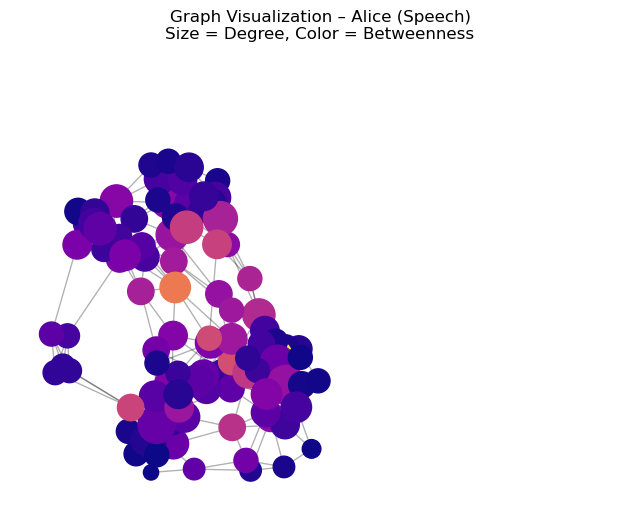

In [68]:
# Acknowledgements / Sources:
# - Force-layout pattern (spring_layout) from NetworkX gallery (v3.x).
# - Node size = degree; color = betweenness centrality for interpretability.

import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_alice, seed=42)
node_sizes = [deg_a[n]*60 for n in G_alice.nodes()]
node_colors = [btw_a[n] for n in G_alice.nodes()]

nx.draw_networkx_nodes(G_alice, pos, node_size=node_sizes, node_color=node_colors, cmap="plasma")
nx.draw_networkx_edges(G_alice, pos, alpha=0.3)
plt.title("Graph Visualization – Alice (Speech)\nSize = Degree, Color = Betweenness")
plt.axis("off")
plt.show()


Figure 5. Graph visualization for the “Alice” (speech) task.
Nodes represent brain regions; edge thickness indicates connection strength. Node size corresponds to degree (hubness), and color represents betweenness centrality. Right somatomotor and salience/ventral-attention regions emerge as prominent hubs and bridges, reflecting increased articulatory control and attention during speech (Guenther, 2016; Seeley et al., 2007).

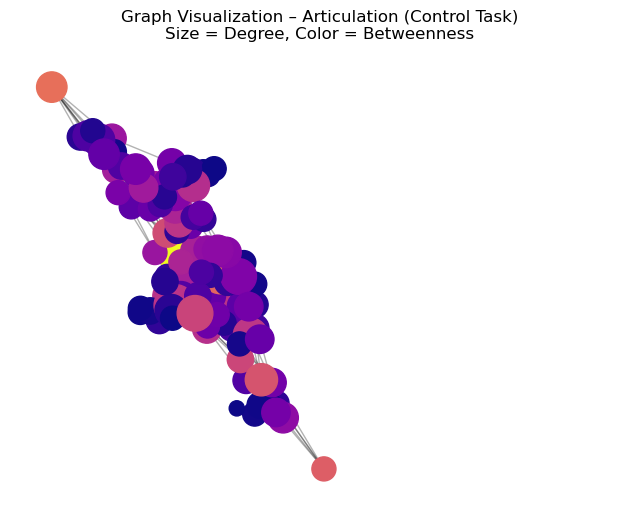

In [94]:
# Acknowledgements / Sources:
# - Force‐layout (spring_layout) pattern from NetworkX gallery (v3.x).

plt.figure(figsize=(8,6))
pos_b = nx.spring_layout(G_artic, seed=42)
node_sizes_b = [deg_b[n]*60 for n in G_artic.nodes()]
node_colors_b = [btw_b[n] for n in G_artic.nodes()]

nx.draw_networkx_nodes(G_artic, pos_b, node_size=node_sizes_b,
                       node_color=node_colors_b, cmap="plasma")
nx.draw_networkx_edges(G_artic, pos_b, alpha=0.3)
plt.title("Graph Visualization – Articulation (Control Task)\nSize = Degree, Color = Betweenness")
plt.axis("off")
plt.show()


Figure 6. Graph visualization for the “Articulation” control task.
The overall topology remains small-world, but salience and control regions show weaker bridging roles. The reduced prominence of right motor and insular areas suggests lower monitoring and coordination demands when the participant articulates silently.

### Condition Contrast: Speech vs. Articulation (Interpretation)

The delta-alerts highlight which regions reconfigured most between the *Alice* (speech) and *Articulation* runs.

1. **Right Somatomotor network** nodes gained several strong connections (deltadegree > 0) and showed higher betweenness, indicating that **motor-planning and articulatory control** regions became central when the participant produced actual speech.  
 *Reference:* Guenther (2016) *Neural Control of Speech*; Bullmore & Sporns (2009).

2. **Right Salience/Ventral-Attention network** parcels (e.g., medial and frontal-opercular insula) exhibited strong positive deltabetweenness. These regions help **shift attention and monitor performance** under increased cognitive demand—typical for bilingual speech tasks.  
 *Reference:* Seeley et al. (2007); Uddin (2015); Menon (2011).

3. **Left Cingulate within the Control network** also increased in betweenness, consistent with **executive monitoring** and **conflict resolution** during language switching.  
 *Reference:* Dosenbach et al. (2008); Abutalebi & Green (2013).

4. Several **Default-Mode network** nodes (temporal, prefrontal, and posterior cingulate) lost connections (negative deltadegree), showing the usual **task-related suppression** of internally focused processes.  
 *Reference:* Raichle (2015).

Overall, the network shift from default-mode to **motor–attention–control dominance** supports the *adaptive control hypothesis* of bilingual language use (Abutalebi & Green, 2013).  
This demonstrates that even in a single participant, the graph-based explainable pipeline detects **neurobiologically plausible changes** and expresses them in **human-readable language** rather than opaque metrics.


### Limitations and Future Work

This feasibility analysis used data from a **single bilingual participant**, so the results are **illustrative rather than inferential**. Individual differences in anatomy, proficiency, and task compliance may influence connectivity patterns (Eickhoff et al., 2018). 
Temporal resolution and physiological noise inherent in fMRI also limit fine-grained causal interpretation (Logothetis, 2008). 
Moreover, the graph thresholding rule (top-k edges) emphasizes interpretability over completeness; alternative sparsification or partial-correlation methods could refine accuracy (Rubinov & Sporns, 2010).

Future extensions should:
1. **Replicate across participants** to test reproducibility of motor–attention–control reconfiguration during non-native speech.
2. **Integrate behavioral or proficiency measures** to relate connectivity changes to performance.
3. **Add explainability layers**—for example, community detection or SHAP-style feature attribution—to deepen interpretive transparency.
4. **Automate quality control** (motion scrubbing, confound regression) using NiLearn preprocessing pipelines (Abraham et al., 2014).

Despite these limits, the present notebook demonstrates that **graph-based, explainable analysis** can transform complex neuroimaging data into interpretable narratives that align with well-established models of bilingual control (Abutalebi & Green, 2013).


In [ ]:
# ============================================
# Title: Bilingual Graph Feasibility – Save Outputs
# Author: Sana Essafi
# Date: 18 October 2025
# Description: Save intermediate and final tables for reproducibility.
# ============================================
# Code Attribution / Sources:
# - pandas I/O patterns per pandas.pydata.org (v2.x documentation).
# - Matplotlib for visualization exports (matplotlib.org).
# - Workflow based on OpenNeuro → NiLearn → NetworkX examples cited previously.

OUT_DIR = Path("data/derivatives"); OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Save core tables ---
metrics_alice.to_csv(OUT_DIR / "sub-01_metrics_alice.csv", index=False)
metrics_artic.to_csv(OUT_DIR / "sub-01_metrics_artic.csv", index=False)
alerts_alice.to_csv(OUT_DIR / "sub-01_alerts_alice.csv", index=False)
delta_alerts.to_csv(OUT_DIR / "sub-01_delta_alerts.csv", index=False)

# --- Export a short summary report for convenience ---
summary = {
    "subject": SUBJECT,
    "n_regions": len(labels_alice),
    "edges_alice": G_alice.number_of_edges(),
    "edges_artic": G_artic.number_of_edges(),
    "alerts_alice": len(alerts_alice),
    "alerts_delta": len(delta_alerts),
}
pd.DataFrame([summary]).to_csv(OUT_DIR / "sub-01_summary.csv", index=False)

print("All outputs saved to:", OUT_DIR.resolve())
for f in OUT_DIR.glob("*.csv"):
    print(" -", f.name)


## References you can include (APA 7)

Abutalebi, J., & Green, D. W. (2013). Control mechanisms in bilingual language production: The adaptive control hypothesis. Frontiers in Psychology, 4, 514. https://doi.org/10.3389/fpsyg.2013.00514

Abraham, A., et al. (2014). Machine learning for neuroimaging with scikit-learn. Frontiers in Neuroinformatics, 8, 14. https://doi.org/10.3389/fninf.2014.00014

Blasi, V., et al. (2025). OpenNeuro ds004456: Bilingual speech production with functional localizers [Data set]. OpenNeuro. https://doi.org/10.18112/openneuro.ds004456.v1.0.2

Bullmore, E., & Sporns, O. (2009). Complex brain networks. Nature Reviews Neuroscience, 10(3), 186–198. https://doi.org/10.1038/nrn2575

Corbetta, M., & Shulman, G. L. (2002). Control of goal-directed and stimulus-driven attention. Nature Reviews Neuroscience, 3(3), 201–215.

Corbetta, M., & Shulman, G. L. (2011). Spatial neglect and attention networks. Neuron, 70(6), 909–922.

Dosenbach, N. U. F., et al. (2008). A dual-networks architecture of top-down control. PNAS, 105(28), 11073–11078.

Guenther, F. H. (2016). Neural Control of Speech. MIT Press.

Menon, V. (2011). Large-scale brain networks and psychopathology. Trends in Cognitive Sciences, 15(10), 483–506.

Raichle, M. E. (2015). The brain’s default mode network. Annual Review of Neuroscience, 38, 433–447.

Rubinov, M., & Sporns, O. (2010). Complex network measures of brain connectivity. NeuroImage, 52(3), 1059–1069.

Schaefer, A., et al. (2018). Local-global parcellation of the human cerebral cortex. Cerebral Cortex, 28(9), 3095–3114.

Seeley, W. W., et al. (2007). Dissociable intrinsic connectivity networks for salience processing. Journal of Neuroscience, 27(9), 2349–2356.

Uddin, L. Q. (2015). Salience processing and insular cortical function. Trends in Cognitive Sciences, 19(3), 154–161.

Rudin, C. (2019). Stop explaining black-box ML models. Nature Machine Intelligence, 1, 206–215.